### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import math
import random

from skimage.io import imread
from skimage.io import imshow
import skimage.transform as trans
from skimage import exposure

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.utils import resample
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder


import tensorflow as tf
import keras
from tensorflow.keras import datasets, layers, models


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Section 1. Data Loading & Data Insights & Further Preprocessing

In [2]:
#Preparation of complete dataset without downsampled sizze

#For simplicity in our code for splitting - the test_data set from the original Kaggle datasets have been merged with the train_set

train_path = 'Alzheimer_s Dataset/train'

categories = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

train_images = []
classImages = []

#Number of train_images of each category for our train_data
numberofimages = []

#similar to rmarkdown to get file directories
for category in categories:
    data_train_path = os.path.join(train_path, category)
    numberofimages.append(len(os.listdir(data_train_path)))

    for file in os.listdir(data_train_path):
        train_image_paths = os.path.join(data_train_path, file) #image in this case refers to title of the image
        train_image = imread(train_image_paths, as_gray=True) #reads an image, imread - image + read and grayscales all train_images
        train_images.append(train_image)





In [3]:
#Amou
print(numberofimages)

[3200, 2240, 896, 64]


In [4]:
#Splitting of dataset into its a list of its respective categories
NonDemented = train_images[0:3200]
VeryMildDemented = train_images[3200:5440]
MildDemented = train_images[5440:6336]
ModerateDemented = train_images[6336:]

lst = [NonDemented, VeryMildDemented, MildDemented, ModerateDemented]

In [5]:
#Check dimensions of each raw data set
print(NonDemented[0].shape)

#check if all data-set has the same dimensions
dim = train_images[0].shape
sum_of_incorrect = 0
for i in train_images:
    if i.shape != dim:
        sum_of_incorrect+=1
print(sum_of_incorrect)

(208, 176)
0


We can see that there is a significant class imbalance which calls for the need of data augmentation

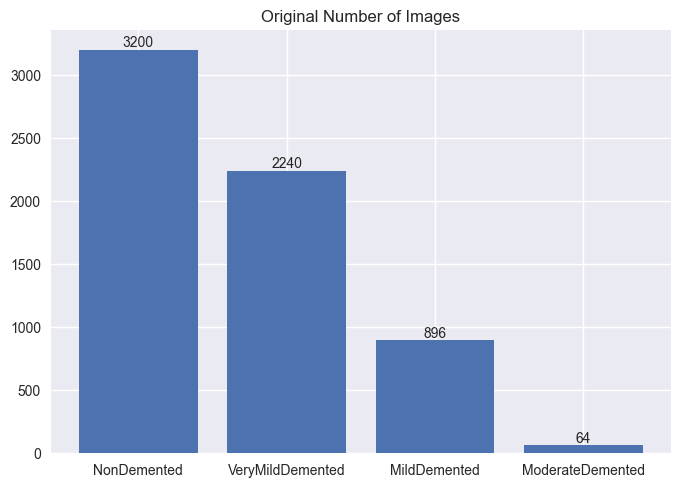

In [6]:
#Plot showing class imbalance
plt.style.use('seaborn')
barplot = plt.bar(categories, numberofimages)
plt.title('Original Number of Images')
plt.bar_label(barplot , labels = numberofimages)
plt.show()

#### Data Augmentations

In [7]:
#Data Augmentations of ModerateDemented
new_ModerateDemented = []
for i in ModerateDemented:
  new_ModerateDemented.append(trans.rotate(i, 12))
  new_ModerateDemented.append(trans.rotate(i, 348)) 
  new_ModerateDemented.append(trans.rotate(i, 5))
  new_ModerateDemented.append(trans.rotate(i,355))
  new_ModerateDemented.append(trans.rotate(i, 10))  
  new_ModerateDemented.append(trans.rotate(i, 350)) 
  new_ModerateDemented.append(trans.rotate(i, 8))
  new_ModerateDemented.append(trans.rotate(i, 362))
  new_ModerateDemented.append(trans.rotate(i, 3))
  new_ModerateDemented.append(trans.rotate(i,357))
  new_ModerateDemented.append(trans.rotate(i[::-1], 180))
  
print(len(new_ModerateDemented))# amount new data points augmented

ModerateDemented += new_ModerateDemented#added new data into ModerateDemented
numberofimages[3] += len(new_ModerateDemented)#updated numbers for image
print(numberofimages) #Number of new images for dataset 1

704
[3200, 2240, 896, 768]


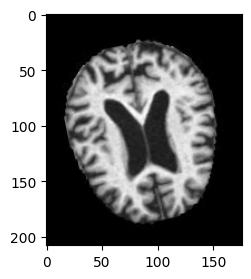

In [8]:
#Showing example of our image augmentation which keeps roughly the similar orientation
plt.style.use('default')
plt.figure(figsize= (3,3))
plt.imshow(new_ModerateDemented[0], cmap = 'gray')
plt.show()

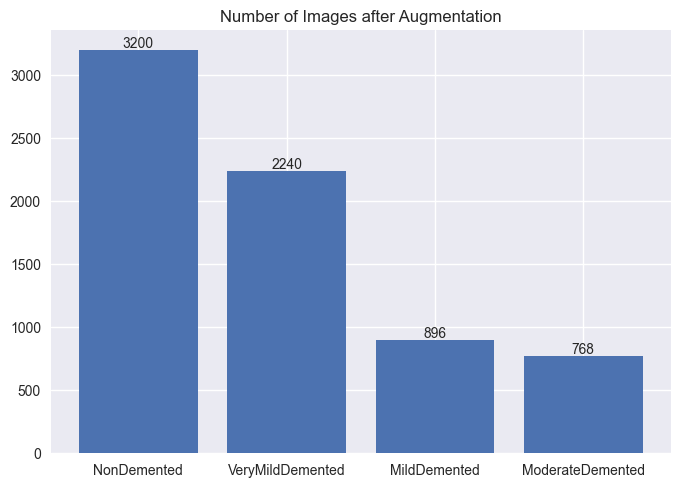

In [9]:
#Data Visualization after augmentation
plt.style.use('seaborn')
barplot = plt.bar(categories, numberofimages)
plt.title('Number of Images after Augmentation')
plt.bar_label(barplot , labels = numberofimages)
plt.show()

#### Downsampling
Even with augmentation, there is an excessive amount of NonDemented and VeryMildDemented. We can perform downsampling to speed up computationational speed while keeping general trend.

In [10]:
downsampled_NonDemented = resample(NonDemented, replace= False, n_samples= len(MildDemented) + 700, random_state=9)
downsampled_VeryMildDemented = resample(VeryMildDemented, replace= False, n_samples= len(MildDemented) + 300, random_state= 9)

#new list for downsampled dataset
downsampled_lst = [downsampled_NonDemented, downsampled_VeryMildDemented, MildDemented, ModerateDemented]

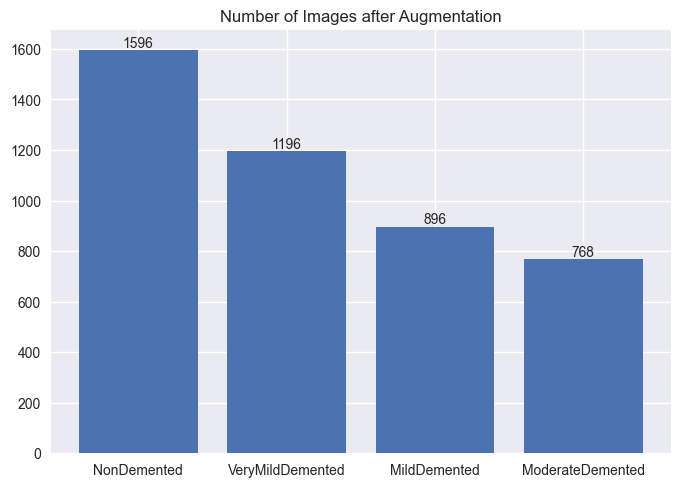

In [11]:
new_numberofimages = [len(downsampled_NonDemented), len(downsampled_VeryMildDemented), len(MildDemented), len(ModerateDemented)]
barplot = plt.bar(categories, new_numberofimages )
plt.style.use('seaborn')
plt.title('Number of Images after Augmentation')
plt.bar_label(barplot , labels = new_numberofimages )
plt.show()

#### Image visualization and adjustments

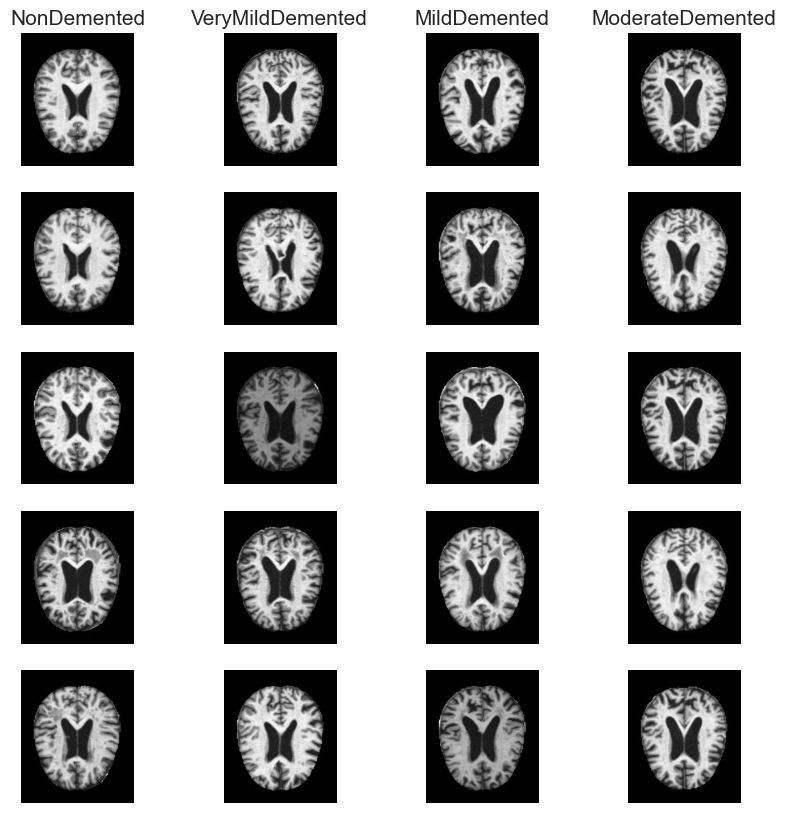

In [12]:
#First 4 pictures to roughly show how each MRI Scan for each category looks like using the original dataset

fig,axes = plt.subplots(5,4, figsize = (10,10))

for i in range(len(lst)):
    for j in range(5):
        img = lst[i][j]
        axes[j,i].imshow(img, cmap = 'gray')
        axes[j,i].axis('off') #turn off axis for each subplot
axes[0,0].set_title('NonDemented', fontsize = 15)
axes[0,1].set_title('VeryMildDemented', fontsize = 15)
axes[0,2].set_title('MildDemented', fontsize = 15)
axes[0,3].set_title('ModerateDemented', fontsize = 15)
plt.show()

The Above picture shows us that some images are darker than others
We can do intensity normalization via adaptive histogram equalization(adaptive to ensure not too contrasted)

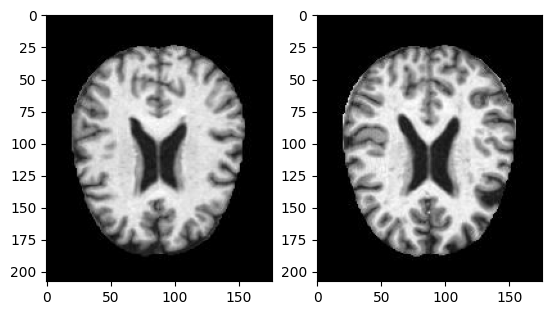

In [13]:
#Original images for first two NonDemented Images to show massive contrast difference
plt.style.use('default')
fig, axes = plt.subplots(1,2)
axes[0].imshow(NonDemented[1], cmap = 'gray')
axes[1].imshow(NonDemented[2], cmap = 'gray')
plt.show()

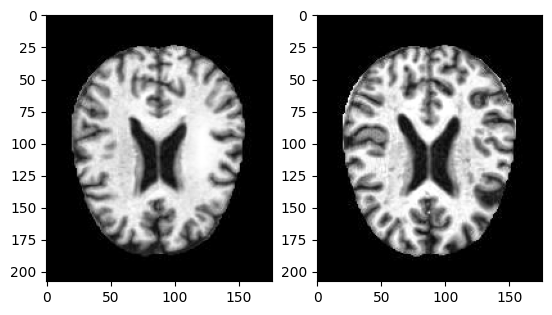

In [14]:
#After adaptive histogram equalization
fig, axes = plt.subplots(1,2)
img = NonDemented[1]
img2 = NonDemented[2]

img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.007, nbins = 200)
img2_adapteq = exposure.equalize_adapthist(img2, clip_limit= 0.007)


axes[0].imshow(img_adapteq, cmap = 'gray')
axes[1].imshow(img2_adapteq, cmap = 'gray')
plt.show()

In [15]:
#Performing histogram equalization for all images
for cat in downsampled_lst:
    for imgidx in range(len(cat)):
        cat[imgidx] = exposure.equalize_adapthist(cat[imgidx], clip_limit = 0.007)



Lets now analyse the the pixels of a 'mean' image of 60 images from each class with a scale of [0,1]


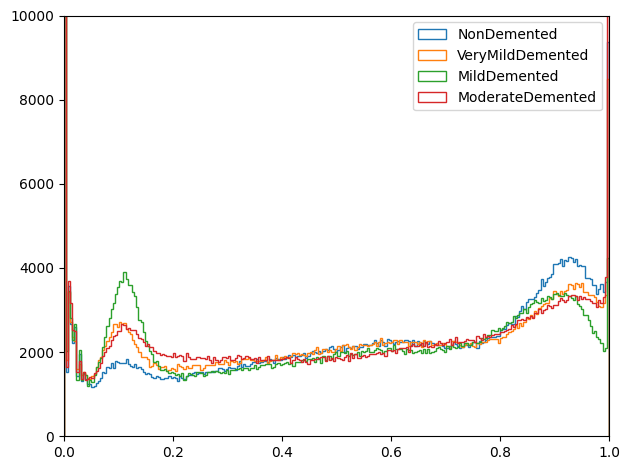

In [ ]:
mean_pixels = []
for cat in downsampled_lst:
    total = 0
    flat = []
    for j in range(30):
        total += cat[j] / 30
        flat.extend(cat[j].flatten())
    mean_pixels.append(flat)


for i in range(len(mean_pixels)):
    plt.hist(mean_pixels[i], bins = 255, histtype = 'step')
    plt.xlim([0,1])
    plt.ylim([0,10000])

plt.legend(categories)
plt.tight_layout()
plt.show()

We can can see that there is significantly less dark pixels for the NonDemented in a specific range from ~0.05 to 0.25. It might be a good idea to use a binary mask filter before passing on dataset to linear models for classification on whether one has Alzheimer or Not

We will also create newBinaryImages_flat which contains flattened matrices of the binary images to allow data to be passed on the scikit-learn model

In [ ]:
#Applying binary mask to all images
newBinaryImages = []
newBinaryImages_flat = []
for cat in downsampled_lst:
    for img in cat:
        img1 = np.array(img)
        #Binary mask
        img1 = np.where((img1 >= 0.06) & (img1<= 0.30), 1,0)
        newBinaryImages.append(img1)
        newBinaryImages_flat.append(img1.flatten())

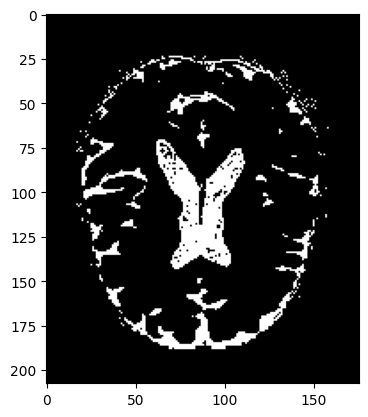

In [ ]:
#Image after binary mask application
plt.imshow(newBinaryImages[0], cmap = 'gray')
plt.show()

### Section 2. Dataset Preparation for Model training

#### Preparation for Linear Model

In [ ]:
#Creating of raw data labels
labels = []
for i in range(len(categories)):
    labels.extend(np.repeat(categories[i], new_numberofimages[i]))

Creating of one-hot coded labels for classification

In [ ]:
classificationLabels = np.where(np.array(labels) == 'NonDemented', 0, 1)

We will create two training sets --  split into a train and validation set since we already have test data

The first set contains the base images

The second set contains images with a binary mask

In [ ]:
#In our downsamples list, we will create flat matrices of the original image
baseImagesFlat = []
for cat in downsampled_lst:
    for image in cat:
        baseImagesFlat.append(image.flatten())

#Flat binary images have already been made above
#newBinaryImages_flat

In [ ]:
baseX_train, baseX_test, baseY_train, baseY_test = train_test_split(baseImagesFlat, classificationLabels, test_size= 0.20, random_state= 9) # 10% Of our data acts as a validation set
binaryX_train, binaryX_test, binaryY_train, binaryY_test = train_test_split(newBinaryImages_flat, classificationLabels, test_size= 0.20, shuffle=True, random_state= 9)

In [ ]:
#Checking if all X_train have same dimensions
for i in baseX_train:
    if len(i) != 36608:
        print('y')

for i in binaryX_train:
    if len(i) != 36608:
        print('y')

One potential improvement is by performing LDA on our dataset to speed up linear model training time. We will do this on our base-images rather than binary images since binary images have less features

In [ ]:
lda = LinearDiscriminantAnalysis()
lda_baseX_train = lda.fit_transform(baseX_train, baseY_train)
lda_baseX_test = lda.transform(baseX_test)


KeyboardInterrupt: 

#### Preparation for CNN Model and mcSVM models

We will create a two training set. Similar to above, one with a binary mask and one without only for the mcSVM dataSet

The first will be the training set for our deep-learning model without a binary mask.

The second will be the training set for our multi-class SVM model #For classification of those WITH strictly

In [ ]:
#cnn data
baseImages3D = []
for cat in downsampled_lst:
    for image in cat:
        baseImages3D.append(image)

baseImages3D = np.array(baseImages3D).reshape(-1, 208,176,1)
newBinaryImages3D = np.array(newBinaryImages).reshape(-1,208,176,1)

In [ ]:
labelsGet = pd.get_dummies(labels)
cnn_labels = labelsGet.values

In [ ]:
#mcSVM dataset
#Here, we will remove NonDemented datasets
mcSVM_images = []
for cat in downsampled_lst[1:]:
    for images in cat:
        mcSVM_images.append(images.flatten())

mcSVM_lab = []
for i in range(len(categories)-1):
    mcSVM_lab.extend(np.repeat(categories[i+1], new_numberofimages[i+1]))

le = LabelEncoder()
le.fit(mcSVM_lab)

mcSVM_labels = le.transform(mcSVM_lab)

#binary_images for mc_SVM
binary_mcSVM = newBinaryImages_flat[1596:]

In [ ]:
mcSVM_X_train, mcSVM_X_test, mcSVM_y_train, mcSVM_y_test = train_test_split(mcSVM_images, mcSVM_labels, random_state= 9)
mcSVM_binary_X_train, mcSVM_binary_X_test, mcSVM_binary_y_train, mcSVM_binary_y_test = train_test_split(binary_mcSVM, mcSVM_labels, random_state= 9)

cnn_X_train, cnn_X_test, cnn_y_train, cnn_y_test = train_test_split(baseImages3D, cnn_labels, test_size= 0.2, random_state= 9)

### Section 3. Model Training

#### Linear Models for Dectection (Binary Classification)

Models will follow this format: Base set, Binary set, LDA set using a KFold of 5. For models using base_images(except lda), we will tune the hyper-parameters as it will likely have maximum iteration problems without converging by using RandomizedSearchCV

In [ ]:
#Default is 5
kf = KFold()

##### Logistic Regression Models

In [ ]:
logregBase_parameters = {'penalty': ['l1','l2'], 'C': list(np.linspace(0.00001,2, num = 7))}
logregBase = RandomizedSearchCV(LogisticRegression(random_state = 9,max_iter = 500), logregBase_parameters, cv = 5)
logregBase.fit(baseX_train,baseY_train)

logregBinary = LogisticRegressionCV(cv = kf, random_state= 9)
logregBinary.fit(binaryX_train, binaryY_train)

logregLDA = LogisticRegressionCV(cv = kf, random_state= 9)
logregLDA.fit(lda_baseX_train, baseY_train)

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sk

LogisticRegressionCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                     random_state=9)

Results

In [ ]:
logregBase_ypred = logregBase.predict(baseX_test)
print(classification_report(logregBase_ypred, baseY_test))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92       300
           1       0.97      0.94      0.96       592

    accuracy                           0.94       892
   macro avg       0.93      0.94      0.94       892
weighted avg       0.94      0.94      0.94       892



In [ ]:
logregBinary_ypred = logregBinary.predict(binaryX_test)
print(classification_report(logregBinary_ypred, binaryY_test))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       301
           1       0.95      0.92      0.93       591

    accuracy                           0.91       892
   macro avg       0.90      0.91      0.90       892
weighted avg       0.91      0.91      0.91       892



In [ ]:
lda_ypred = logregLDA.predict(lda_baseX_test)
print(classification_report(lda_ypred, baseY_test))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       304
           1       0.94      0.92      0.93       588

    accuracy                           0.91       892
   macro avg       0.90      0.91      0.90       892
weighted avg       0.91      0.91      0.91       892



##### SVM Models using Linear Kernel

In [ ]:
base_svm = LinearSVC(max_iter = 500)
base_svm.fit(baseX_train, baseY_train)

binary_svm = LinearSVC(max_iter = 500)
binary_svm.fit(binaryX_train, binaryY_train)

lda_svm = LinearSVC()
lda_svm.fit(baseX_train, baseY_train)

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\User

LinearSVC()

In [ ]:
base_svm_ypred = base_svm.predict(baseX_test)
print(classification_report(base_svm_ypred, baseY_test))


              precision    recall  f1-score   support

           0       0.91      0.97      0.94       301
           1       0.98      0.95      0.97       591

    accuracy                           0.96       892
   macro avg       0.95      0.96      0.95       892
weighted avg       0.96      0.96      0.96       892



In [ ]:
binary_svm_ypred = binary_svm.predict(binaryX_test)
print(classification_report(binary_svm_ypred, binaryY_test))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       300
           1       0.95      0.92      0.93       592

    accuracy                           0.91       892
   macro avg       0.90      0.91      0.90       892
weighted avg       0.91      0.91      0.91       892



In [ ]:
lda_svm = LinearSVC()
lda_svm.fit(baseX_train, baseY_train)
lda_svm_ypred = lda_svm.predict(baseX_test)
print(classification_report(lda_svm_ypred, baseY_test))

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.93      0.96      0.94       309
           1       0.98      0.96      0.97       583

    accuracy                           0.96       892
   macro avg       0.95      0.96      0.96       892
weighted avg       0.96      0.96      0.96       892



Save trained models into pickle file for re-use

In [ ]:
import pickle

pickle.dump(logregBase , open('logregBase.pkl' , 'wb'))
pickle.dump(logregBinary , open('logregBinary.pkl' , 'wb'))
pickle.dump(logregLDA, open('logregLDA.pkl' , 'wb'))


pickle.dump(base_svm , open('base_svm.pkl' , 'wb'))
pickle.dump(binary_svm , open('binary_svm.pkl' , 'wb'))
pickle.dump(lda_svm , open('lda_svm.pkl' , 'wb'))

#### mcSVM Models for Classification of Severity

We will train using two different kernels and check the classification report. Kernels used are rbf and polynomial

In [ ]:
rbf = SVC(kernel = 'rbf')
poly = SVC(kernel = 'poly')

rbfBinary = SVC(kernel = 'rbf') #we will only be using rbf kernel for binary to target specific locations

In [ ]:
rbf.fit(mcSVM_X_train, mcSVM_y_train)

poly.fit(mcSVM_X_train, mcSVM_y_train)

rbfBinary.fit(mcSVM_binary_X_train, mcSVM_binary_y_train)

SVC()

In [ ]:
rbf_ypred = rbf.predict(mcSVM_X_test)
classification_report(rbf_ypred, mcSVM_y_test)

'              precision    recall  f1-score   support\n\n           0       0.82      0.91      0.86       193\n           1       1.00      1.00      1.00       175\n           2       0.95      0.89      0.92       347\n\n    accuracy                           0.92       715\n   macro avg       0.92      0.93      0.93       715\nweighted avg       0.93      0.92      0.92       715\n'

In [ ]:
poly_ypred = poly.predict(mcSVM_X_test)
classification_report(poly_ypred, mcSVM_y_test)

'              precision    recall  f1-score   support\n\n           0       0.99      0.98      0.99       217\n           1       1.00      0.99      1.00       176\n           2       0.98      0.99      0.99       322\n\n    accuracy                           0.99       715\n   macro avg       0.99      0.99      0.99       715\nweighted avg       0.99      0.99      0.99       715\n'

In [ ]:
rbfBinary_ypred = rbfBinary.predict(mcSVM_binary_X_test)
classification_report(rbfBinary_ypred, mcSVM_binary_y_test)

'              precision    recall  f1-score   support\n\n           0       0.92      0.95      0.93       209\n           1       1.00      1.00      1.00       175\n           2       0.97      0.95      0.96       331\n\n    accuracy                           0.96       715\n   macro avg       0.96      0.97      0.96       715\nweighted avg       0.96      0.96      0.96       715\n'

In [ ]:
pickle.dump(rbf , open('rbf.pkl' , 'wb'))
pickle.dump(poly , open('poly.pkl' , 'wb'))
pickle.dump(rbfBinary, open('rbfBinary.pkl' , 'wb'))


#### Overall Method using Deep-Learning

#### CNN Model for Detection & Classification

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3), activation = 'relu', input_shape = (208,176,1), padding = 'same'))
model.add(layers.Conv2D(16, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(32, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.Conv2D(32, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D())
model.add(layers.Dropout(0.1)) #regularization

model.add(layers.Conv2D(128, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.Conv2D(128, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D())
model.add(layers.Dropout(0.1))


model.add(layers.Conv2D(256, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.Conv2D(256, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D())
model.add(layers.Dropout(0.1))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.BatchNormalization())


model.add(layers.Dense(4, activation='softmax'))

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 208, 176, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 208, 176, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 104, 88, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 104, 88, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 104, 88, 32)    │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 104, 88, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 52, 44, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 52, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 52, 44, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 52, 44, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 26, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 26, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 26, 22, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 26, 22, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 26, 22, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 13, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 13, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 13, 11, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 13, 11, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 13, 11, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 6, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 6, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 7680)           │             

 Total params: 15,565,470 (59.38 MB)

 Trainable params: 5,187,700 (19.79 MB)

 Non-trainable params: 2,368 (9.25 KB)

 Optimizer params: 10,375,402 (39.58 MB)

In [ ]:
opt = keras.optimizers.Adam(learning_rate = 0.0008)
model.compile(optimizer= opt, loss= 'categorical_crossentropy', metrics= ['accuracy', 'precision', 'recall'])

In [ ]:
history = model.fit(cnn_X_train, cnn_y_train, epochs = 10)

Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 99s 833ms/step - accuracy: 0.4587 - loss: 1.4185 - precision: 0.5021 - recall: 0.3604
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 98s 876ms/step - accuracy: 0.6900 - loss: 0.7242 - precision: 0.7659 - recall: 0.5991
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 102s 915ms/step - accuracy: 0.7516 - loss: 0.5916 - precision: 0.8047 - recall: 0.6903
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 103s 923ms/step - accuracy: 0.8053 - loss: 0.4691 - precision: 0.8439 - recall: 0.7680
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 106s 950ms/step - accuracy: 0.8592 - loss: 0.3672 - precision: 0.8786 - recall: 0.8314
Epoch 6/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 104s 927ms/step - accuracy: 0.8891 - loss: 0.2979 - precision: 0.9068 - recall: 0.8712
Epoch 7/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 103s 919ms/step - accuracy: 0.8747 - loss: 0.3351 - precision: 0.8879 - recall: 0.8587
Epoch 8/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 103s 922ms/step - accuracy: 0.9339 - loss: 0.2070 - precision: 0.9390 - r

In [ ]:
model.save('cnnh5.h5')